In [4]:
import torch
from IPython import display
from d2l import torch as d2l

### 定义bs，即每次乱序抽取256个，得到两个训练和测试集的迭代器

In [8]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### softmax每一次计算输入要求是一个1维向量，所以要将3维拉成1维，（1×28×28）

In [9]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)
W.shape

torch.Size([784, 10])

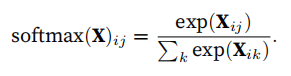
### 这里X是一个矩阵,softmax如下实现

In [10]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这⾥应⽤了⼴播机制

In [11]:
# X = torch.normal(0, 1, (2, 5))
# X_prob = softmax(X)
# X_prob, X_prob.sum(1)

### 将x变为二维张量，注意也是softmax每次输入计算的是一维，要将图像拉成一维张量。在这里X为(256,784),256为一个bs
### 然后再将X与W进行矩阵乘法，再通过广播机制加上b，此时得到的是上述公式中的（X）ij
### 最终通过net得到的y_hat尺寸为（bs）

In [12]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 定义损失函数
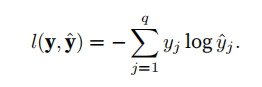
### 细节：y_hat为对2个样本在3个类别的预测概率，以及他们对应的标签y；由y可知，在第一个样本中第一类是正确的标签类，第二个样本中第三个是正确的标签类；然后使用y作为y_hat的索引，选择第一个样本中第一个类和第二个样本中第三个类的概率

In [5]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

### 这样在一个bs中有256个10个类别得分的情况下，根据256个标签tensor，即可索引出对应标签类的预测分数
### 进而带入-log(y_hat_j),原公式中y为独热向量，对应索引后yj即为1，其他为0
### 这个例子对应输出第一个样本的交叉熵，即-log0.1=2.3026。输入的y_hat是(bs,cls),输出（bs）

In [6]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 这里if判断的是y_hat的行数和列数大于1；(2,3)取len为2！！
### .argmax(axis=1)返回的是y_hat里面沿行最大的数的位置，这里为[2, 2]
### cmp是一个bool列表，包含0(False),1(True)的张量，在此为[False, True]
### '=='运算符对type很敏感，故还要统一成y的type

In [7]:
def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [8]:
accuracy(y_hat, y) / len(y), len(y_hat.shape), y_hat

(0.5,
 2,
 tensor([[0.1000, 0.3000, 0.6000],
         [0.3000, 0.2000, 0.5000]]))

In [17]:
def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

### 在Accumulator中创建了2个变量，分别用于存储正确预测的数量和预测的总数量
### 这个类用于对多个变量进行累加

In [18]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

evaluate_accuracy(net, test_iter)

0.1636

In [19]:
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    """训练模型⼀个迭代周期（定义⻅第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使⽤PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使⽤定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

### train_epoch_ch3函数最终返回的是训练损失值和精确度（正确预测/总）

In [20]:
class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使⽤lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [38]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    """训练模型（定义⻅第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        # print(f'训练损失{train_metrics[0]},精确度{train_metrics[1]}')
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [39]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

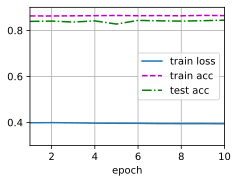

In [40]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [28]:
a = 2.0000315
print(f'测试{a:7f}')

测试2.000031
